In [44]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from mtr.models import model as model_utils
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset import WaymoDataset
from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical



cfg_file = 'tools/cfgs/waymo/bc+10_percent_data.yaml'
ckpt_path = 'output/bc/epoch=2-step=4602.ckpt'
cfg = cfg_from_yaml_file(cfg_file, cfg)

dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
mtr_inference = MTRInference(cfg_file)
mtr_inference.load_from_checkpoint(ckpt_path)
mtr_inference.model.eval()
env = BatchMTREnv(1, dataset)
_ = env.envs_list[0].reset(0)


=========== MTR Inference ===========


In [46]:
def sample_control(pred_ctrl, pred_ctrl_score, log_std_range=(-4.0, -1.0), rho_limit=0.4):
    '''
    Construct a Gaussian Mixture Model for the control sampling
    input:
        pred_ctrl: (num_center_objects, num_query, 6 or 9)
        pred_ctrl_score: (num_center_objects, num_query)
    output:
    '''
    
    independent = pred_ctrl.shape[-1] == 6
    
    mean = pred_ctrl[..., 0:3] # (num_center_objects, num_query, 3)
    log_std1 = torch.clip(pred_ctrl[..., 3], min=log_std_range[0], max=log_std_range[1])
    log_std2 = torch.clip(pred_ctrl[..., 4], min=log_std_range[0], max=log_std_range[1])
    log_std3 = torch.clip(pred_ctrl[..., 5], min=log_std_range[0], max=log_std_range[1])
    std1 = torch.exp(log_std1)
    std2 = torch.exp(log_std2)
    std3 = torch.exp(log_std3)
    # print(std1)
    # print(std2)
    # print(std3)
    if independent:
        rho1 = rho2 = rho3 = torch.zeros_like(log_std1)
    else:
        rho1 = torch.clip(pred_ctrl[..., 6], min=-rho_limit, max=rho_limit) # 1&2
        rho2 = torch.clip(pred_ctrl[..., 7], min=-rho_limit, max=rho_limit) # 1&3
        rho3 = torch.clip(pred_ctrl[..., 8], min=-rho_limit, max=rho_limit) # 2&3 
        
    covariance = torch.stack([
        torch.stack([std1**2, rho1*std1*std2, rho2*std1*std3], dim=-1),
        torch.stack([rho1*std1*std2, std2**2, rho3*std2*std3], dim=-1),
        torch.stack([rho2*std1*std3, rho3*std2*std3, std3**2], dim=-1),
    ], dim=-1) # (num_center_objects, num_query, 3, 3)
    # print(covariance)
    dist_mode = MultivariateNormal(mean, covariance_matrix=covariance)
    # print(dist_mode.batch_shape, dist_mode.event_shape)
    mix = Categorical(logits=pred_ctrl_score)
    gmm = MixtureSameFamily(mix, dist_mode)
    return gmm

In [47]:
def sample_most_likely_control(pred_ctrl, pred_ctrl_score):
    '''
    Construct a Gaussian Mixture Model for the control sampling
    input:
        pred_ctrl: (num_center_objects, num_query, 6 or 9)
        pred_ctrl_score: (num_center_objects, num_query)
    output:
    '''
        
    mean = pred_ctrl[..., 0:3] # (num_center_objects, num_query, 3)
    index = torch.argmax(pred_ctrl_score, dim=-1).cpu().detach()
    control = mean[torch.arange(mean.shape[0]), index]
    return control

In [225]:
_ = env.reset()


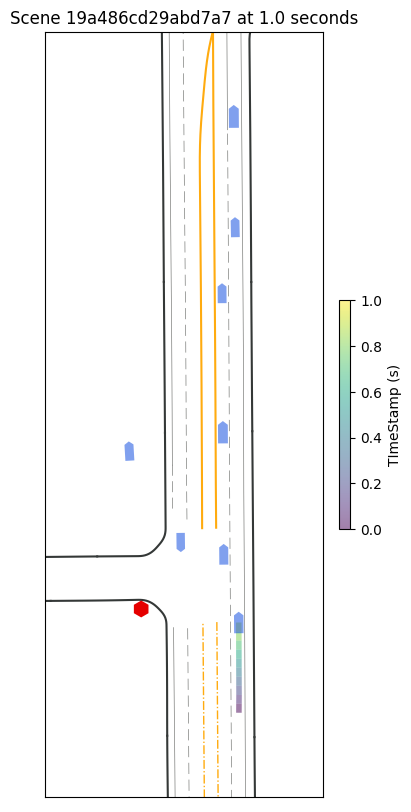

In [3]:
batch_scene_data = env.batch_scene_data
with torch.no_grad():
    batch_pred_dicts = mtr_inference.inference(batch_scene_data)
_ = env.visualize(batch_dict= batch_pred_dicts)
# pred_ctrl = batch_pred_dicts['pred_ctrl']
# pred_ctrl_scores = batch_pred_dicts['pred_ctrl_scores']
# gmm = sample_control(pred_ctrl, pred_ctrl_scores)
# # action = sample_most_likely_control(pred_ctrl, pred_ctrl_scores)
# action = gmm.sample()
# action = action.cpu().numpy()
# _ = env.step(action)


In [50]:
print(torch.functional.F.softmax(pred_ctrl_scores, dim=-1)[0])
print(gmm.mixture_distribution.probs[0])

tensor([3.9057e-07, 6.8851e-07, 6.0495e-10, 5.9911e-09, 4.7640e-07, 4.5018e-06,
        9.2483e-10, 2.3422e-06, 9.4534e-08, 9.9011e-08, 1.8621e-06, 9.7633e-07,
        2.8640e-07, 7.9138e-01, 3.4623e-06, 7.6585e-10, 2.8520e-08, 4.0999e-07,
        1.5492e-05, 3.0019e-07, 5.9348e-02, 8.0116e-07, 1.7961e-07, 2.6380e-10,
        4.6672e-05, 1.2987e-05, 1.5571e-07, 2.5193e-06, 3.4330e-06, 3.1794e-07,
        5.1772e-10, 2.1708e-06, 6.9794e-07, 3.6146e-09, 2.0689e-09, 4.6316e-07,
        3.3029e-02, 5.4606e-06, 7.2087e-06, 1.0689e-01, 4.7901e-10, 5.8459e-07,
        6.3649e-09, 2.6022e-06, 4.4359e-05, 4.2070e-08, 1.0109e-06, 3.1226e-08,
        6.9237e-12, 1.5935e-07, 7.1646e-08, 2.4839e-07, 6.7223e-05, 1.4681e-09,
        8.8426e-03, 1.2304e-07, 2.6230e-04, 1.2104e-11, 4.9266e-07, 6.8543e-07,
        1.8474e-08, 1.1285e-05, 2.8106e-06, 5.4346e-08], device='cuda:0')


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 print(torch.functional.F.softmax(pred_ctrl_scores, dim=-1)[0])                               │
│ ❱ 2 print(gmm.mixture_distribution.probs[0])                                                     │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'gmm' is not defined

In [51]:
pred_ctrl = batch_pred_dicts['pred_ctrl']
pred_ctrl_scores = batch_pred_dicts['pred_ctrl_scores']
print(sorted(torch.functional.F.softmax(pred_ctrl_scores, dim=-1)[0].cpu().numpy()))

gmm, dist_mode, mix = sample_control(pred_ctrl, pred_ctrl_scores)
gmm_samples = gmm.sample((1000,)).cpu().numpy()
gaussian_samples = dist_mode.sample((100,)).cpu().numpy()
print(gaussian_samples.shape)
i = 0
# _ = plt.plot(gaussian_samples[:,0,:,0], gaussian_samples[:,0,:,1], 'x', alpha=0.1)
plt.plot(gmm_samples[:, i, 0], gmm_samples[:, i, 1], 'o', alpha=0.1)


[6.9237324e-12, 1.2103946e-11, 2.6379737e-10, 4.790129e-10, 5.1771815e-10, 6.049483e-10, 7.6584594e-10, 9.2482844e-10, 1.4681423e-09, 2.0688886e-09, 3.6146293e-09, 5.991097e-09, 6.3649e-09, 1.8474303e-08, 2.851952e-08, 3.1225632e-08, 4.2070244e-08, 5.4345726e-08, 7.1645566e-08, 9.453373e-08, 9.901138e-08, 1.2304363e-07, 1.5570825e-07, 1.5934788e-07, 1.796051e-07, 2.4838957e-07, 2.8639565e-07, 3.0019334e-07, 3.1793513e-07, 3.905727e-07, 4.0998628e-07, 4.6316413e-07, 4.7640316e-07, 4.926615e-07, 5.8458824e-07, 6.854267e-07, 6.8851375e-07, 6.979411e-07, 8.0115706e-07, 9.763252e-07, 1.0108604e-06, 1.8621314e-06, 2.170812e-06, 2.3422251e-06, 2.5193149e-06, 2.602198e-06, 2.8105576e-06, 3.4330483e-06, 3.462288e-06, 4.5017555e-06, 5.460627e-06, 7.2086877e-06, 1.1285456e-05, 1.2987437e-05, 1.5492129e-05, 4.4359313e-05, 4.6672245e-05, 6.722303e-05, 0.00026229702, 0.008842616, 0.033029217, 0.059347652, 0.10689474, 0.7913773]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2 pred_ctrl_scores = batch_pred_dicts['pred_ctrl_scores']                                     │
│    3 print(sorted(torch.functional.F.softmax(pred_ctrl_scores, dim=-1)[0].cpu().numpy()))        │
│    4                                                                                             │
│ ❱  5 gmm, dist_mode, mix = sample_control(pred_ctrl, pred_ctrl_scores)                           │
│    6 gmm_samples = gmm.sample((1000,)).cpu().numpy()                                             │
│    7 gaussian_samples = dist_mode.sample((100,)).cpu().numpy()                                   │
│    8 print(gaussian_samples.shape)                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: cannot unpack non-iterable MixtureSameFamily object